# Naive NN 

We will implement a Feed Forward NN that uses the peptide low-dim vector with the HLA flatten representation for peptide binding classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os


In [2]:
# PATH
DATA_FOLDER = os.path.join('..', 'data')
PROCESS_DATA_FOLDER = os.path.join(DATA_FOLDER, 'processed')
PROCESS_pHLA_BINDING_FOLDER = os.path.join(PROCESS_DATA_FOLDER, 'pHLA_binding')

PROCESS_NETMHCPAN_pHLA_FOLDER = os.path.join(PROCESS_pHLA_BINDING_FOLDER, 'NetMHCpan_dataset')

# CONSTANTS
N_WORKERS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_LABELS = 2
N_EPOCHS = 2
EXP_NAME = 'naive_nn'
CHEKPOINT_FOLDER = os.path.join('.', 'checkpoints', EXP_NAME)
os.makedirs(CHEKPOINT_FOLDER, exist_ok=True)

In [3]:
# File paths

# Only using binding affinity data for training
train_data = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'train_ba_merged_enc.npy')
train_labels = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'train_ba_labels.npy')
test_data = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'test_merged_enc.npy')
test_labels = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'test_labels.npy')



In [4]:
class Data(Dataset):
    def __init__(self, X_train: np.array, y_train: np.array):
        self.X = torch.from_numpy(X_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.float32)
        self.len = self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

In [5]:
class Network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x
        

In [6]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def eval_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    return running_loss / len(val_loader)

def train(model, train_loader, val_loader,
          optimizer, criterion, n_epochs, device,
          checkpoint_path=None):
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = eval_one_epoch(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if checkpoint_path:
                torch.save(model.state_dict(), os.path.join(checkpoint_path, 'best_model.t7'))
        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {round(train_loss, 4)} - Val Loss: {round(val_loss, 4)} - Best Val Loss: {round(best_val_loss, 4)}')
    return train_losses, val_losses

def test(model, test_loader, device, compute_roc=False):
    model.eval()
    y_true = []
    y_pred = []
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, outputs = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().detach().numpy())
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    if compute_roc:
        roc_auc = roc_auc_score(y_true, y_pred)
        # plot roc curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC AUC: {roc_auc}')
        plt.show()
    return y_true, y_pred

In [7]:
# Load data
X_train = np.load(train_data)#[:1000, :]
y_train = np.load(train_labels)#[:1000]
X_test = np.load(test_data)#[:1000, :]
y_test = np.load(test_labels)#[:1000]

# Convert to one-hot encoding
y_train = np.eye(N_LABELS)[y_train]
y_test = np.eye(N_LABELS)[y_test]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_data = Data(X_train, y_train)
val_data = Data(X_val, y_val)
test_data = Data(X_test, y_test)

train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, num_workers=N_WORKERS)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True, num_workers=N_WORKERS)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=True, num_workers=N_WORKERS)

del X_train, y_train, X_val, y_val, X_test, y_test

 50%|█████     | 1/2 [00:09<00:09,  9.23s/it]

Epoch 1/2 - Train Loss: 0.561 - Val Loss: 0.5602 - Best Val Loss: 0.5602


100%|██████████| 2/2 [00:19<00:00,  9.86s/it]

Epoch 2/2 - Train Loss: 0.561 - Val Loss: 0.5603 - Best Val Loss: 0.5602


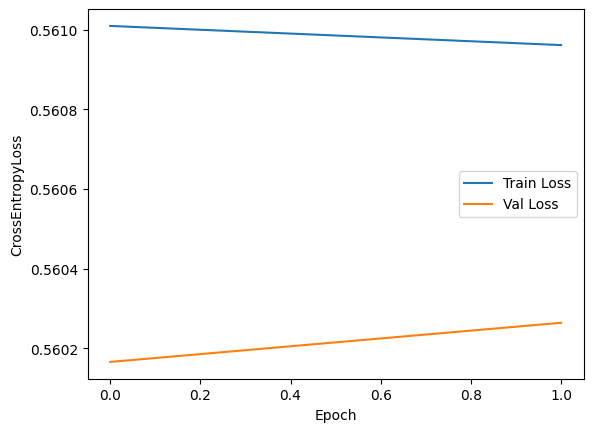

In [8]:
input_dim = train_data[0][0].shape[0]
model = Network(input_dim=input_dim, hidden_dim=64, output_dim=N_LABELS)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, N_EPOCHS, DEVICE, checkpoint_path=CHEKPOINT_FOLDER)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.legend()
plt.show()

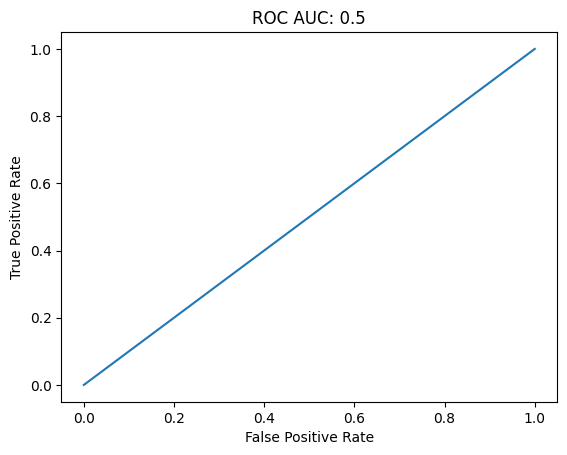

In [9]:
best_model_path = os.path.join(CHEKPOINT_FOLDER, 'best_model.t7')
model.load_state_dict(torch.load(best_model_path))
y_true, y_pred = test(model, test_loader, DEVICE, compute_roc=True)